In [2]:
import warnings
warnings.simplefilter('ignore')

# Model Training

In this tutorial we are going to train a model from scratch on a molecular dataset from the MD17 collection.
Start by creating a project folder and downloading the dataset.

## Acquiring a dataset

You can obtain the benzene dataset with DFT labels either by running the following command or manually from this [link](http://www.quantum-machine.org/gdml/data/xyz/ethanol_ccsd_t.zip). Apax uses ASE to read in datasets, so make sure to convert your own data into an ASE readable format (extxyz, traj etc). Be carefull the downloaded dataset has to be modified like in the `apax.untils.dataset.mod_md_datasets` function in order to be readable.

In [3]:
from pathlib import Path
from apax.utils.datasets import mod_md_datasets, download_etoh_ccsdt

data_path = Path("project")

train_file_path, test_file_path = download_etoh_ccsdt(data_path)
train_file_path = mod_md_datasets(train_file_path)
test_file_path = mod_md_datasets(test_file_path)


## Configuration files

Next, we require a configuration file that specifies the model and training parameters.
In order to get users quickly up and running, our command line interface provides an easy way to generate input templates.
The provided templates come in in two levels of verbosity: minimal and full.
In the following we are going to use a minimal input file. To see a complete list and explanation of all parameters, consult the documentation page LINK.
For more information on the CLI,  simply run `apax -h`.

In [4]:
!apax -h

                                                                                
 Usage: apax [OPTIONS] COMMAND [ARGS]...                                        
                                                                                
╭─ Options ────────────────────────────────────────────────────────────────────╮
│ --version             -V                                                     │
│ --install-completion            Install completion for the current shell.    │
│ --show-completion               Show completion for the current shell, to    │
│                                 copy it or customize the installation.       │
│ --help                -h        Show this message and exit.                  │
╰──────────────────────────────────────────────────────────────────────────────╯
╭─ Commands ───────────────────────────────────────────────────────────────────╮
│ docs       Opens the documentation website in your browser.                  │
│ eval       Starts performi

The following command create a minimal configuration file in the working directory. Full configuration file with descriptiond of the prameter can be found [here](https://github.com/apax-hub/apax/blob/main/apax/cli/templates/train_config_full.yaml).

In [5]:
!apax template train

Open the resulting `config.yaml` file in an editor of your choice and make sure to fill in the data path field with the name of the data set you just downloaded.
For the purposes of this tutorial we will train on 1000 data points and validate the model on 200 more during the training. Further, the units of the labels have to be specified. Random splitting is done by apax but it is also possible to input a pre-splitted training and validation dataset.

In order to check whether the a configuration file is valid, we provide the `validate` command. This is especially convenient when submitting training runs on a compute cluster.

In [6]:
!apax validate train config.yaml

1 validation error for Config
n_epochs
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='<NUMBER OF EPOCHS>', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/int_parsing
Configuration Invalid!


Configuration files are validated using Pydantic and the errors provided by the `validate` command give precise instructions on how to fix the input file. The filled in configuration file should look similar to this one.

```yaml
data:
  batch_size: 32
  data_path: project/ethanol_ccsd_t-train_mod.xyz
  directory: project/models
  energy_unit: kcal/mol
  experiment: ethanol_ccsd_t_cli
  n_train: 990
  n_valid: 10
  pos_unit: Ang
  valid_batch_size: 100
loss:
- name: energy
- name: forces
  weight: 4.0
metrics:
- name: energy
  reductions:
  - mae
- name: forces
  reductions:
  - mae
  - mse
model:
  descriptor_dtype: fp64
n_epochs: 100

```

It also can be modefied with the utils function `mod_config` provided by Apax.

In [7]:
from apax.utils.helpers import mod_config
import yaml


config_path = Path("config.yaml")

config_updates = {
    "n_epochs": 100,
    "data": {
        "n_train": 990,
        "n_valid": 10,
        "valid_batch_size": 1,
        "experiment": "ethanol_ccsd_t_cli",
        "directory": "project/models",
        "data_path": str(train_file_path),
        "test_data_path": str(test_file_path),
        "energy_unit": "kcal/mol",
        "pos_unit": "Ang",
    },
    "model": {
        "descriptor_dtype": "fp64"
    },
}
config_dict = mod_config(config_path, config_updates)

with open("config.yaml", "w") as conf:
    yaml.dump(config_dict, conf, default_flow_style=False)

In [8]:
!apax validate train config.yaml

Success!
config.yaml is a valid training config.


## Training

Model training can be started by running

In [9]:
!apax train config.yaml

INFO | 12:22:53 | Running on [cuda(id=0)]
INFO | 12:22:53 | Initializing Callbacks
INFO | 12:22:53 | Initializing Loss Function
INFO | 12:22:53 | Initializing Metrics
INFO | 12:22:53 | Running Input Pipeline
INFO | 12:22:53 | Read data file project/ethanol_ccsd_t-train_mod.xyz
INFO | 12:22:53 | Loading data from project/ethanol_ccsd_t-train_mod.xyz
INFO | 12:22:54 | Computing per element energy regression.
INFO | 12:22:54 | Initializing Model
INFO | 12:22:54 | initializing 1 models
INFO | 12:23:03 | Initializing Optimizer
INFO | 12:23:04 | Beginning Training
Epochs: 100%|█████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s, val_loss=0.105]
INFO | 12:23:52 | Finished training




During training, apax displays a progress bar to keep track of the validation loss.
This progress bar is optional however and can be turned off in the config.
The default configuration writes training metrics to a CSV file, but TensorBoard is also supported.
One can specify which to use by adding the following section to the input file:

```yaml
callbacks:
    - CSV
```

If training is interrupted for any reason, re-running the above `train` command will resume training from the latest checkpoint.

Furthermore, an Apax trianing can easily be started within a script.

In [10]:
from apax.train.run import run
from apax.utils.helpers import mod_config


config_path = Path("config.yaml")

config_updates = {
    "data": {
        "experiment": "ethanol_ccsd_t_script",
    },
}

config_dict = mod_config(config_path, config_updates)

run(config_dict)

Epochs: 100%|█████████████████████████████████████| 100/100 [00:47<00:00,  2.12it/s, val_loss=0.105]


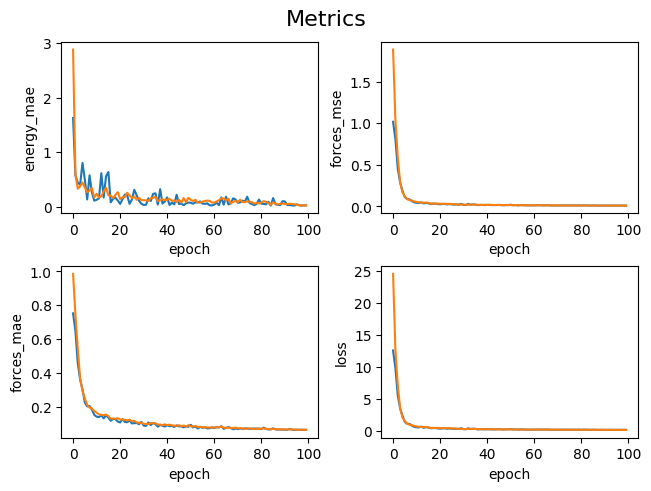

In [11]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from apax.utils.helpers import load_csv_metrics

metrics_path = "project/models/ethanol_ccsd_t_script/log.csv"
keys = ["energy_mae", "forces_mse", "forces_mae", "loss"]

data_dict = load_csv_metrics(metrics_path)

fig, axes = plt.subplots(2, 2, constrained_layout=True)
axes = axes.ravel()
fig.suptitle(f'Metrics', fontsize=16)

for id, key in enumerate(keys):
    val = np.array(data_dict[f"val_{key}"])
    train = np.array(data_dict[f"train_{key}"])
    epoch = np.array(data_dict["epoch"])

    axes[id].plot(epoch, val, label="val data")
    axes[id].plot(epoch, train, label="train data")

    axes[id].set_ylabel(f"{key}")
    axes[id].set_xlabel(r"epoch")

plt.show()

## Evaluation

After the training is completed and we are satisfied with our choice of hyperparameters and vadliation loss, we can evaluate the model on the test set.
We provide a separate command for test set evaluation:


In [12]:
from apax.train.eval import eval_model

eval_model(config_dict)

Structure: 100%|███████████████████████████████| 999/999 [00:03<00:00, 280.74it/s, test_loss=0.0838]


In [13]:
!apax eval config.yaml

Structure: 100%|███████████████████████████████| 999/999 [00:04<00:00, 214.87it/s, test_loss=0.0837]


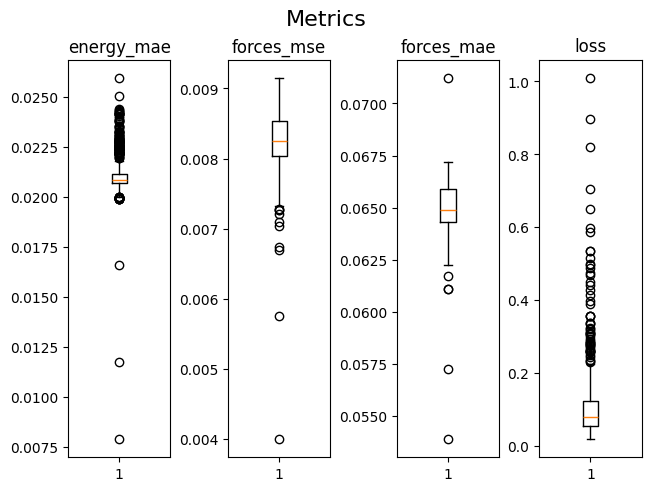

In [14]:
metrics_path = "project/models/ethanol_ccsd_t_script/eval/log.csv"
keys = ["energy_mae", "forces_mse", "forces_mae", "loss"]

data_dict = load_csv_metrics(metrics_path)

fig, axes = plt.subplots(1, 4, constrained_layout=True)
axes = axes.ravel()
fig.suptitle(f'Metrics', fontsize=16)

for id, key in enumerate(keys):
    test = np.array(data_dict[f"test_{key}"])

    axes[id].set_title(f'{key}')
    axes[id].boxplot(test)
plt.show()

Congratulations, you have successfully trained and evaluated your first apax model!

## A Closer Look At Training Parameters

To remove all the created files and clean up yor working directory run

In [15]:
!rm -rf project config.yaml eval.log